# Training and evaluation

Load and prepare dataset

In [3]:
import pandas as pd

FEATURES = [
    "Depth (m)",
    "qc (MPa)",
    "fs (kPa)",
    "Rf (%)",
    "σ,v (kPa)",
    "u0 (kPa)",
    "σ',v (kPa)",
    "Qtn (-)",
    "Fr (%)",
]
LABELS = "Oberhollenzer_classes"
FILEPATH_TRAIN = "../data/model_ready/dataset_train.csv"
FILEPATH_TEST = "../data/model_ready/dataset_test.csv"

df_train = pd.read_csv(FILEPATH_TRAIN, header=0)
df_test = pd.read_csv(FILEPATH_TEST)
df_full = pd.concat([df_train, df_test], axis=0)

X_train = df_train[FEATURES]
y_train = df_train[LABELS]
X_test = df_test[FEATURES]
y_test = df_test[LABELS]

# remove class 3.0
# df_train = df_train[df_train[LABELS] != 3.0]

df_train.head()

,ID,test_type,basin_valley,Depth (m),qc (MPa),fs (kPa),Rf (%),"σ,v (kPa)",u0 (kPa),"σ',v (kPa)",Qtn (-),Fr (%),Oberhollenzer_classes
0,850,CPT,Zell basin,0.05,6.85,5.8,0.09,0.95,0.49,0.46,263.95,0.09,4.0
1,850,CPT,Zell basin,0.06,7.92,11.6,0.17,1.14,0.59,0.55,315.95,0.17,4.0
2,850,CPT,Zell basin,0.07,9.44,23.2,0.21,1.33,0.69,0.64,339.46,0.21,4.0
3,850,CPT,Zell basin,0.08,10.84,23.2,0.23,1.52,0.78,0.74,364.64,0.23,4.0
4,850,CPT,Zell basin,0.09,11.28,25.6,0.22,1.71,0.88,0.83,369.59,0.22,4.0


In [2]:
df_test.head()

,ID,test_type,basin_valley,Depth (m),qc (MPa),fs (kPa),Rf (%),"σ,v (kPa)",u0 (kPa),"σ',v (kPa)",Qtn (-),Fr (%),Oberhollenzer_classes
0,849,CPT,Zell basin,0.39,0.06,0.01,0.01,7.41,3.83,3.58,23.33,0.01,4.0
1,849,CPT,Zell basin,0.40,0.22,0.01,0.01,7.60,3.92,3.68,13.40,0.01,4.0
2,849,CPT,Zell basin,0.41,0.05,0.01,0.01,7.79,4.02,3.77,12.04,0.01,4.0
3,849,CPT,Zell basin,0.42,0.02,0.01,0.04,7.98,4.12,3.86,4.32,0.05,4.0
4,849,CPT,Zell basin,0.43,0.01,0.01,0.11,8.17,4.22,3.95,0.49,0.59,4.0


## Exploring performance boundaries and computational effort

We will compare some main groups of models and their performance on the dataset. We will also explore the computational effort required to train and evaluate these models.

### Dummy classifier - an interesting model always need to better than this.

**NOTE**: To reference a benchmark model in a scientific paper you should also check if there are other model performance benchmarks relevant on the dataset using other statistical, numerical or mathematical methods.

In [4]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)
y_pred = dummy_model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00     24578
         2.0       0.00      0.00      0.00     46628
         3.0       0.00      0.00      0.00      2196
         4.0       0.00      0.00      0.00     22981
         5.0       0.22      1.00      0.35     47640
         6.0       0.00      0.00      0.00     41385
         7.0       0.00      0.00      0.00     35553

    accuracy                           0.22    220961
   macro avg       0.03      0.14      0.05    220961
weighted avg       0.05      0.22      0.08    220961



Some new terms from the classification report:
- support: number of occurrences of each class in y_true
- weighted avg: average of the metrics, weighted by the support values
- macro avg: average of the metrics for each class. Macro avg for recall is the same as balanced accuracy.

### A linear model

**NOTE about scaling**: Apart from tree-based models, most models are sensitive to the scaling of the input features. It is a good practice to scale the input features before training the model.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# scaling the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(x_train_scaled, y_train)
y_pred_lr = lr_model.predict(x_test_scaled)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         1.0       0.55      0.44      0.49     24578
         2.0       0.52      0.33      0.40     46628
         3.0       0.00      0.00      0.00      2196
         4.0       0.48      0.04      0.07     22981
         5.0       0.37      0.66      0.47     47640
         6.0       0.29      0.18      0.22     41385
         7.0       0.38      0.63      0.47     35553

    accuracy                           0.40    220961
   macro avg       0.37      0.33      0.30    220961
weighted avg       0.42      0.40      0.37    220961



### KNN

A simple non-linear model which is computationally efficient but often quite powerful

In [6]:
from sklearn.neighbors import KNeighborsClassifier

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluating the model
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

         1.0       0.41      0.43      0.42     24578
         2.0       0.43      0.43      0.43     46628
         3.0       0.23      0.05      0.08      2196
         4.0       0.30      0.28      0.29     22981
         5.0       0.40      0.40      0.40     47640
         6.0       0.36      0.42      0.39     41385
         7.0       0.45      0.40      0.42     35553

    accuracy                           0.40    220961
   macro avg       0.37      0.34      0.35    220961
weighted avg       0.40      0.40      0.39    220961



### Extra Trees (Extremely Randomized Trees)

A tree based model which is computationally efficient and often performs better than the classic Random Forest. The main difference to Random Forest is heavier regularization and less variance, leading to less overfitting.

Tree-based models do not require scaling of the input features.

In [7]:
from sklearn.ensemble import ExtraTreesClassifier

et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_model.fit(X_train, y_train)
y_pred_et = et_model.predict(X_test)
print(classification_report(y_test, y_pred_et))

              precision    recall  f1-score   support

         1.0       0.43      0.44      0.43     24578
         2.0       0.45      0.44      0.45     46628
         3.0       0.26      0.06      0.10      2196
         4.0       0.30      0.29      0.30     22981
         5.0       0.41      0.40      0.40     47640
         6.0       0.37      0.43      0.40     41385
         7.0       0.46      0.43      0.44     35553

    accuracy                           0.41    220961
   macro avg       0.38      0.36      0.36    220961
weighted avg       0.41      0.41      0.41    220961



### Random Forest

The classic Random Forest for comparison. Note the extra computational effort required to train and evaluate this model, compared to the previous models.

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.43      0.43      0.43     24578
         2.0       0.47      0.46      0.46     46628
         3.0       0.24      0.06      0.10      2196
         4.0       0.31      0.29      0.30     22981
         5.0       0.41      0.40      0.41     47640
         6.0       0.37      0.43      0.40     41385
         7.0       0.46      0.44      0.45     35553

    accuracy                           0.41    220961
   macro avg       0.38      0.36      0.36    220961
weighted avg       0.41      0.41      0.41    220961



### XGBoost

We complete the exploration by training an XGBoost model. This model is computationally expensive to train and evaluate if you do not have a GPU, but often among the best performing models for tabular data. The other top performing models for tabular data are usually `LightGBM` and `CatBoost`. Usually these tree-based models also perform better than a neural network on tabular data.

**NOTE**: XGBoost has a Scikit-learn API (not including GPU support), but the XGBoost library also has a native API which can be used for faster training and evaluation. The implementation below uses the native API.

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

X_train = df_train[FEATURES]
y_train = df_train[LABELS]
X_test = df_test[FEATURES]
y_test = df_test[LABELS]

# Adjust labels to start from 0 (required for XGBoost with multiclass)
y_train = y_train - 1
y_test = y_test - 1

# Convert the balanced training data to DMatrix (with GPU support)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for using GPU with multiclass classification
params = {
    "objective": "multi:softmax",  # Use multiclass objective (softmax or softprob)
    "num_class": 7,  # Number of classes
    "device": "cuda",  # use cpu if you don't have GPU on the machine
    "random_state": 42,
}

# Train the XGBoost model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions (output is directly class labels)
y_pred = xgb_model.predict(dtest)

# Transform predictions back to original label range for reporting
y_test = y_test + 1
y_pred = y_pred + 1

# Evaluate performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.52      0.49      0.51     24578
         2.0       0.52      0.46      0.49     46628
         3.0       0.29      0.05      0.09      2196
         4.0       0.38      0.27      0.31     22981
         5.0       0.44      0.51      0.48     47640
         6.0       0.40      0.48      0.43     41385
         7.0       0.47      0.46      0.46     35553

    accuracy                           0.45    220961
   macro avg       0.43      0.39      0.40    220961
weighted avg       0.46      0.45      0.45    220961



## Balancing the dataset

Since the KNN is computationally efficient and among the better performers, we will use that to exemplify the topics of scaling and balancing the dataset. **NOTE**: The increased score for class 3 is due to the balancing of the dataset.

In balancing it might work well to first undersample the majority classes to a certain level and then oversample the minority classes to a certain level. This is a common approach to balance the dataset. The levels are often chosen based on the class distribution in the dataset, and is a hyperparameter that can be tuned.

Best practise:

- Undersample the majority classes to reduce their dominance, thus addressing computational challenges and ensuring training is not biased towards these classes.
- Oversample the minority classes to generate synthetic examples that provide more training data for classes with few samples, thus reducing the risk of the model neglecting them. Do not blindly oversample to the same size as the majority classes, as this can lead to overfitting due to synthetic instances being overly similar to each other. 
- It is generally advisable to oversample to a level where the minority classes have enough examples to be statistically significant but without creating a perfect balance. For example, aim for the minority class to reach 70-90% of the size of the majority class.
- The levels of undersampling and oversampling can be tuned as hyperparameters, using cross-validation to find the best values. Inspect the class distribution in the training set and set some initial levels based on this distribution.

In [8]:
# y_train value counts before undersampling
y_train.value_counts()

Oberhollenzer_classes
4.0    154960
1.0    131428
5.0    127006
6.0    117754
3.0     71218
0.0     64971
2.0      2127
Name: count, dtype: int64

Based on the distribution it seems like these levels are ok:
- Undersample majority classes to 110 000 samples
- Oversample minority classes to 75 000 samples

In [9]:
# Import necessary libraries
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

X_train = df_train[FEATURES]
y_train = df_train[LABELS]
X_test = df_test[FEATURES]
y_test = df_test[LABELS]

# Step 1: Scaling the data
scaler = StandardScaler()
# Use the pro suffix to indicate that the data is processed, to avoid overwriting the
# original data, and to facilitate easy commenting out of the processing steps
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inspect the initial class distribution
class_counts = y_train.value_counts()
print("Initial class distribution in y_train:\n", class_counts)

# Set desired levels for undersampling and oversampling
undersample_level = (
    110000  # Target number of samples for majority classes after undersampling
)
oversample_level = (
    75000  # Target number of samples for minority classes after oversampling
)

# Define undersampling strategy for RandomUnderSampler
majority_classes = class_counts[class_counts > undersample_level].index
undersample_dict = dict.fromkeys(majority_classes, undersample_level)

# Apply RandomUnderSampler to reduce majority classes
undersampler = RandomUnderSampler(sampling_strategy=undersample_dict, random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(
    X_train_scaled, y_train
)

# Inspect class distribution after undersampling
resampled_class_counts = pd.Series(y_train_resampled).value_counts()
print("Class distribution after undersampling:\n", resampled_class_counts)

# Set oversampling strategy for SMOTE using a dictionary
# Here, each class below the desired oversample level will be increased to oversample_level
oversample_dict = {
    cls: oversample_level
    for cls in resampled_class_counts.index
    if resampled_class_counts[cls] < oversample_level
}

# Apply SMOTE to oversample minority classes
smote = SMOTE(sampling_strategy=oversample_dict, random_state=42)
X_train_final, y_train_final = smote.fit_resample(X_train_resampled, y_train_resampled)

# Inspect class distribution after oversampling
final_class_counts = pd.Series(y_train_final).value_counts()
print("Class distribution after oversampling:\n", final_class_counts)

Initial class distribution in y_train:
 Oberhollenzer_classes
5.0    154960
2.0    131428
6.0    127006
7.0    117754
4.0     71218
1.0     64971
3.0      2127
Name: count, dtype: int64
Class distribution after undersampling:
 Oberhollenzer_classes
2.0    110000
6.0    110000
5.0    110000
7.0    110000
4.0     71218
1.0     64971
3.0      2127
Name: count, dtype: int64
Class distribution after oversampling:
 Oberhollenzer_classes
2.0    110000
6.0    110000
5.0    110000
7.0    110000
1.0     75000
3.0     75000
4.0     75000
Name: count, dtype: int64


Inspecting the scaled and resampled features

In [10]:
X_train_final = pd.DataFrame(X_train_final, columns=FEATURES)
X_train_final.head()

,Depth (m),qc (MPa),fs (kPa),Rf (%),"σ,v (kPa)",u0 (kPa),"σ',v (kPa)",Qtn (-),Fr (%)
0,-0.945435,1.052641,0.524283,-0.759694,-0.945435,-0.868345,-1.004867,1.472888,-0.828425
1,-0.944481,1.114847,0.642760,-0.739400,-0.944481,-0.867372,-1.003953,1.546258,-0.812933
2,-0.943527,1.147194,0.599532,-0.759694,-0.943527,-0.866497,-1.002938,1.568050,-0.828425
3,-0.942573,1.240502,0.557905,-0.786754,-0.942573,-0.865525,-1.002025,1.645988,-0.854246
4,-0.941619,1.340031,0.437827,-0.840872,-0.941619,-0.864552,-1.001111,1.714981,-0.890395


In [11]:
# Step 3: Train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_final, y_train_final)

# Step 4: Make predictions and evaluate
y_pred_final = knn_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred_final))

c:\Users\TFH\AppData\Local\pypoetry\Cache\virtualenvs\cpt-to-soiltype-BQnqxes--py3.11\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

         1.0       0.39      0.46      0.43     24578
         2.0       0.44      0.42      0.43     46628
         3.0       0.19      0.21      0.20      2196
         4.0       0.29      0.29      0.29     22981
         5.0       0.41      0.36      0.38     47640
         6.0       0.37      0.42      0.39     41385
         7.0       0.44      0.41      0.43     35553

    accuracy                           0.39    220961
   macro avg       0.36      0.37      0.36    220961
weighted avg       0.40      0.39      0.39    220961



## Pipeline for training and evaluation
To avoid data leakage and for a more condense implementation we use a `Pipeline` from `sklearn`. Since we use `SMOTE` for balancing the dataset, we need to use the `imbalanced-learn` version of the `Pipeline`.

In [12]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Define feature and label sets
X_train = df_train[FEATURES]
y_train = df_train[LABELS]
X_test = df_test[FEATURES]
y_test = df_test[LABELS]

# Set desired levels for undersampling and oversampling
undersample_level = 110000
oversample_level = 75000

# Define undersampling strategy
undersample_dict = {
    cls: undersample_level
    for cls in y_train.value_counts().index
    if y_train.value_counts()[cls] > undersample_level
}

# Define oversampling strategy
oversample_dict = {
    cls: oversample_level
    for cls in y_train.value_counts().index
    if y_train.value_counts()[cls] < oversample_level
}


# Create pipeline for preprocessing and model fitting
pipeline = make_pipeline(
    StandardScaler(),
    RandomUnderSampler(sampling_strategy=undersample_dict, random_state=42),
    SMOTE(sampling_strategy=oversample_dict, random_state=42),
    KNeighborsClassifier(n_neighbors=5),
)

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_final = pipeline.predict(X_test)
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

         1.0       0.39      0.46      0.43     24578
         2.0       0.44      0.42      0.43     46628
         3.0       0.19      0.21      0.20      2196
         4.0       0.29      0.29      0.29     22981
         5.0       0.41      0.36      0.38     47640
         6.0       0.37      0.42      0.39     41385
         7.0       0.44      0.41      0.43     35553

    accuracy                           0.39    220961
   macro avg       0.36      0.37      0.36    220961
weighted avg       0.40      0.39      0.39    220961



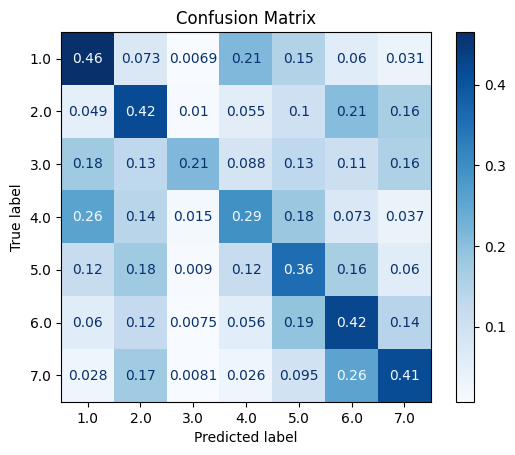

In [13]:
# Step 6: Compute confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_final, normalize="true")

# Visualise the confusion matrix in the standard scikit-learn way
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=knn_model.classes_
)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

### A code version with enhanced visualisation of the confusion matrix

In [14]:
# optional function to make the CM prettier.
def add_black_grid_lines(ax):
    """
    Adds black grid lines around each square in the confusion matrix.

    Parameters:
    ax (matplotlib.axes._axes.Axes): The axes object of the plot.
    """
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_edgecolor("black")
    ax.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
    ax.set_xticks(np.arange(conf_matrix.shape[1]) + 0.5, minor=True)
    ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=True)
    ax.tick_params(which="minor", size=0)

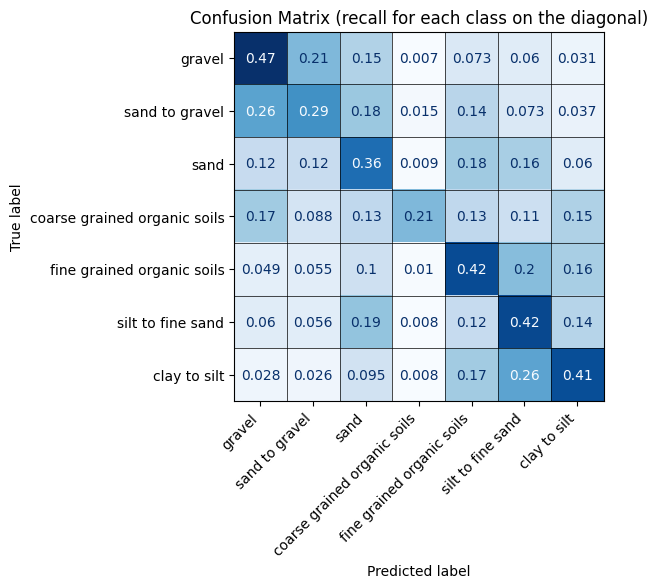

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Mapping table of class names with updated ordering
# The table is reordered to better match the physical properties of the soils
soil_classification = {
    1: "gravel",
    4: "sand to gravel",
    5: "sand",
    3: "coarse grained organic soils",
    2: "fine grained organic soils",
    6: "silt to fine sand",
    7: "clay to silt",
}

# Update the labels using the mapping table with map function
class_labels = list(soil_classification.values())

# Generate the confusion matrix with labels in the desired order
class_label_numbers = list(soil_classification.keys())
conf_matrix = confusion_matrix(
    y_test, y_pred_final, labels=class_label_numbers, normalize="true"
)

# Round the values in the confusion matrix to a maximum of 3 digits behind the comma
conf_matrix = np.round(conf_matrix, 3)

# Visualise the confusion matrix with an optional thin black line around each square
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap="Blues", ax=ax, colorbar=False)

# Toggle black grid lines on or off
add_black_lines = True
if add_black_lines:
    add_black_grid_lines(ax)

# Ensure labels align correctly with ticks
ax.set_xticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels, rotation=45, ha="right")
ax.set_yticks(np.arange(len(class_labels)))
ax.set_yticklabels(class_labels)

plt.title("Confusion Matrix (recall for each class on the diagonal)")
plt.show()

## Cross validation

Cross validation with a standard stratified k-fold splitter (wrong version)

In [50]:
from sklearn.model_selection import StratifiedKFold, cross_validate

X_combined = df_full[FEATURES]
y_combined = df_full[LABELS]

# Create pipeline for scaling, oversampling, and KNN model
pipeline = make_pipeline(
    StandardScaler(),
    SMOTE(random_state=42, sampling_strategy="auto"),
    KNeighborsClassifier(n_neighbors=5),
)

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["balanced_accuracy", "precision_macro", "recall_macro", "accuracy"]
cross_val_results = cross_validate(
    pipeline, X_combined, y_combined, cv=cv, scoring=scoring
)

# Print cross-validation results
print("Cross-Validation Results:")
print("Balanced Accuracy:", cross_val_results["test_balanced_accuracy"].mean())
print("Precision:", cross_val_results["test_precision_macro"].mean())
print("Recall:", cross_val_results["test_recall_macro"].mean())
print("Accuracy:", cross_val_results["test_accuracy"].mean())

# print all values for balanced accuracy
print(cross_val_results["test_balanced_accuracy"])

Cross-Validation Results:
Balanced Accuracy: 0.7482288238743285
Precision: 0.67381852720243
Recall: 0.7482288238743285
Accuracy: 0.7482056321419547
[0.74745281 0.74779364 0.7460119  0.74933314 0.75055263]


New try with a grouped splitter which dont split the same drillhole in train and test set (correct version for this dataset)

In [ ]:
from sklearn.model_selection import GroupKFold, cross_validate

X_combined = df_full[FEATURES + ["ID"]]
y_combined = df_full[LABELS]

groups = X_combined["ID"]  # Use the drillhole ID to group the data

# Drop the ID column for training
X_combined = X_combined[FEATURES]

# Create pipeline for scaling, oversampling, and KNN model
pipeline = make_pipeline(
    StandardScaler(),
    SMOTE(random_state=42, sampling_strategy="auto"),
    KNeighborsClassifier(n_neighbors=5),
)

# Perform cross-validation using GroupKFold to ensure no drillhole is split between train and test
cv = GroupKFold(n_splits=5)
scoring = ["balanced_accuracy", "precision_macro", "recall_macro", "accuracy"]
cross_val_results = cross_validate(
    pipeline, X_combined, y_combined, cv=cv, groups=groups, scoring=scoring
)

# Print cross-validation results
print("Cross-Validation Results:")
print("Balanced Accuracy:", cross_val_results["test_balanced_accuracy"].mean())
print("Precision:", cross_val_results["test_precision_macro"].mean())
print("Recall:", cross_val_results["test_recall_macro"].mean())
print("Accuracy:", cross_val_results["test_accuracy"].mean())

# print all values for balanced accuracy
print(cross_val_results["test_balanced_accuracy"])

Cross-Validation Results:
Balanced Accuracy: 0.36366846531943675
Precision: 0.3379056758446408
Recall: 0.36366846531943675
Accuracy: 0.3855910042160221
[0.35103631 0.36325454 0.36486082 0.36499763 0.37419303]
